In [6]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
import requests
import IPython as ipd

songs = pd.read_csv('dataset.csv')

acoustic             1000
afrobeat             1000
psych-rock           1000
progressive-house    1000
power-pop            1000
                     ... 
emo                  1000
electronic           1000
electro              1000
world-music          1000
k-pop                 999
Name: track_genre, Length: 114, dtype: int64


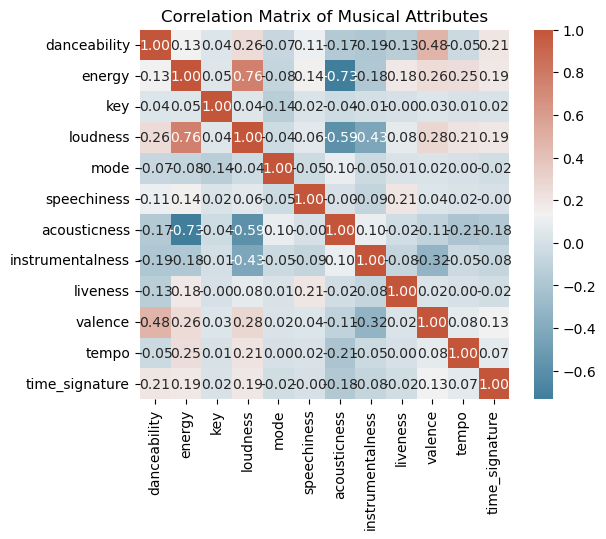

In [7]:
# Get count of null values and unexplanatory features
null_counts = songs.isnull().sum().sum()# 3 missing, drop these rows with null values
songs = songs.dropna().drop(columns=['track_id','popularity','album_name','duration_ms','explicit'])

# Get counts for each genre
genre = songs['track_genre'].value_counts()
print(genre)

# What musical attributes are correlated with each other?
cols =['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature']

# Generate a correlation matrix to see what features are associated with each other
numeric_df = songs[cols]
corr = numeric_df.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap=cmap, square=True)
plt.title('Correlation Matrix of Musical Attributes')
plt.show()

More significant positive correlations: energy with loudness, valence with danceability 
More significant negative correlations: energy/loudness with acousticness, instrumentalness with loudness

To observe trends between different genres, we will plot how levels of each numerical variable vary across different genres. 

/var/folders/1_/0px29c8j2051nd3xr36_5vwr0000gn/T/ipykernel_9641/713306608.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_df = songs.groupby(category).mean()


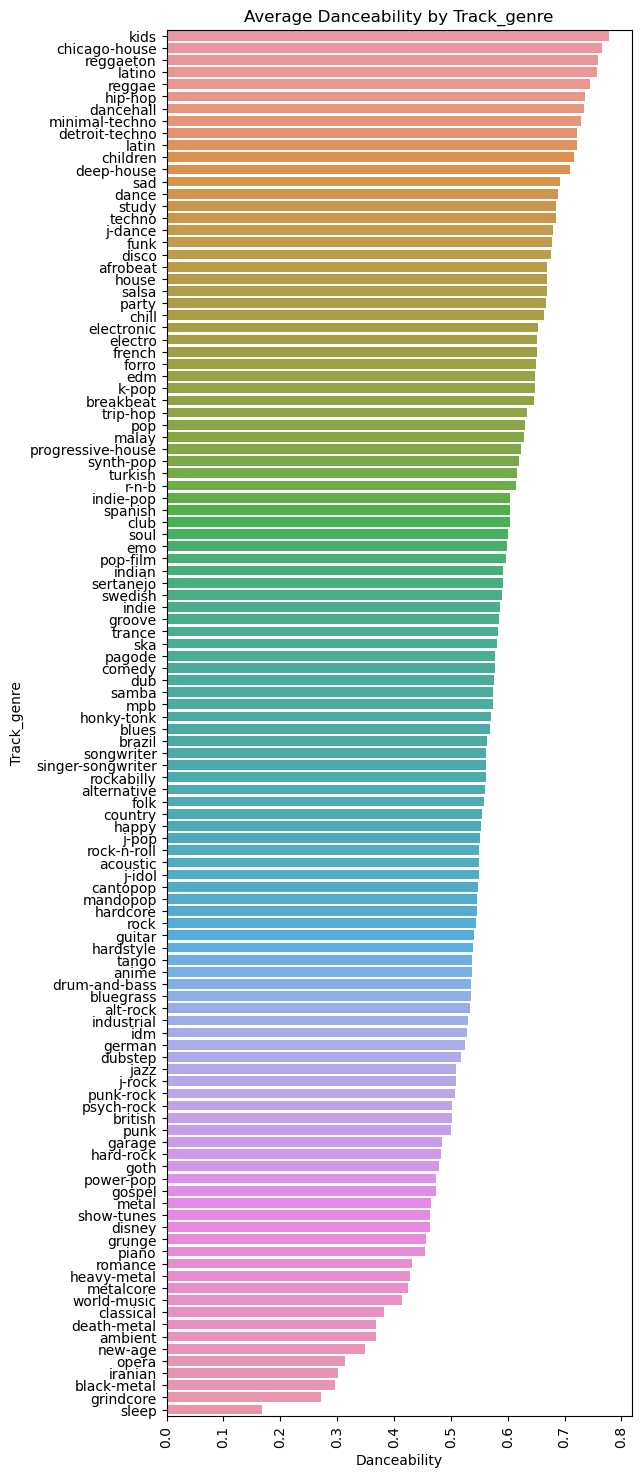

/var/folders/1_/0px29c8j2051nd3xr36_5vwr0000gn/T/ipykernel_9641/713306608.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_df = songs.groupby(category).mean()


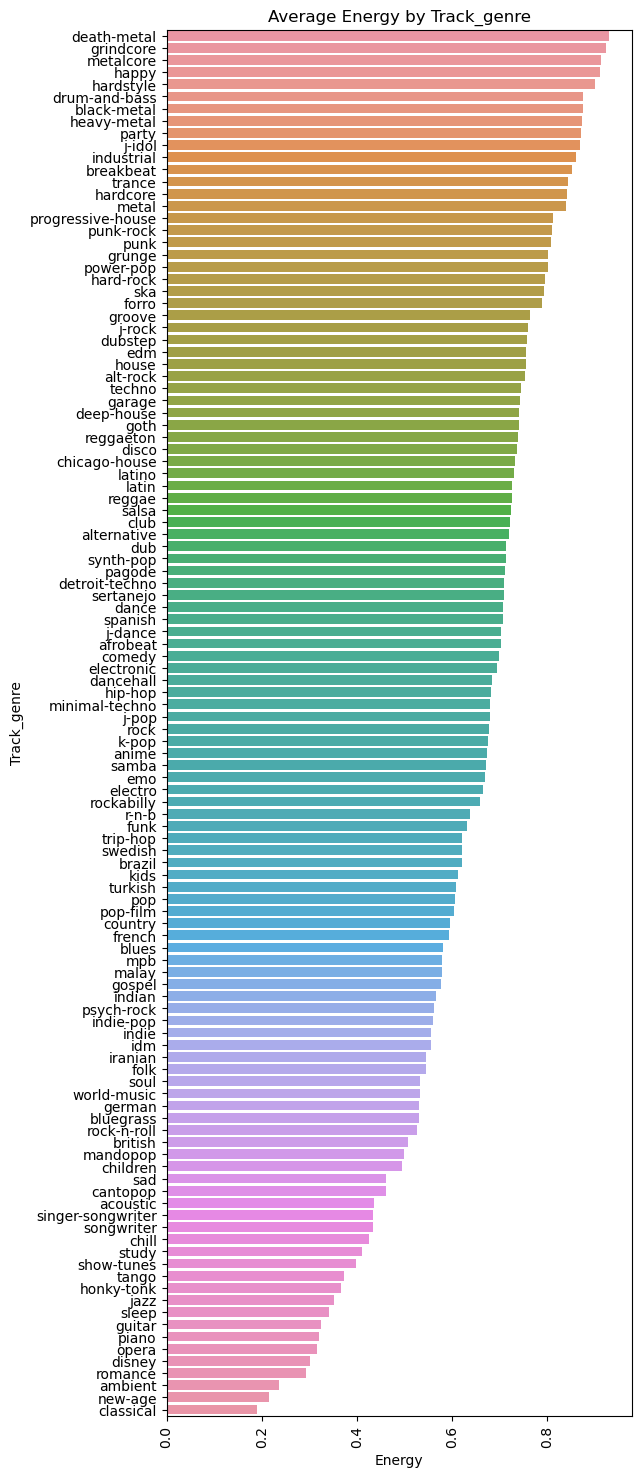

/var/folders/1_/0px29c8j2051nd3xr36_5vwr0000gn/T/ipykernel_9641/713306608.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_df = songs.groupby(category).mean()


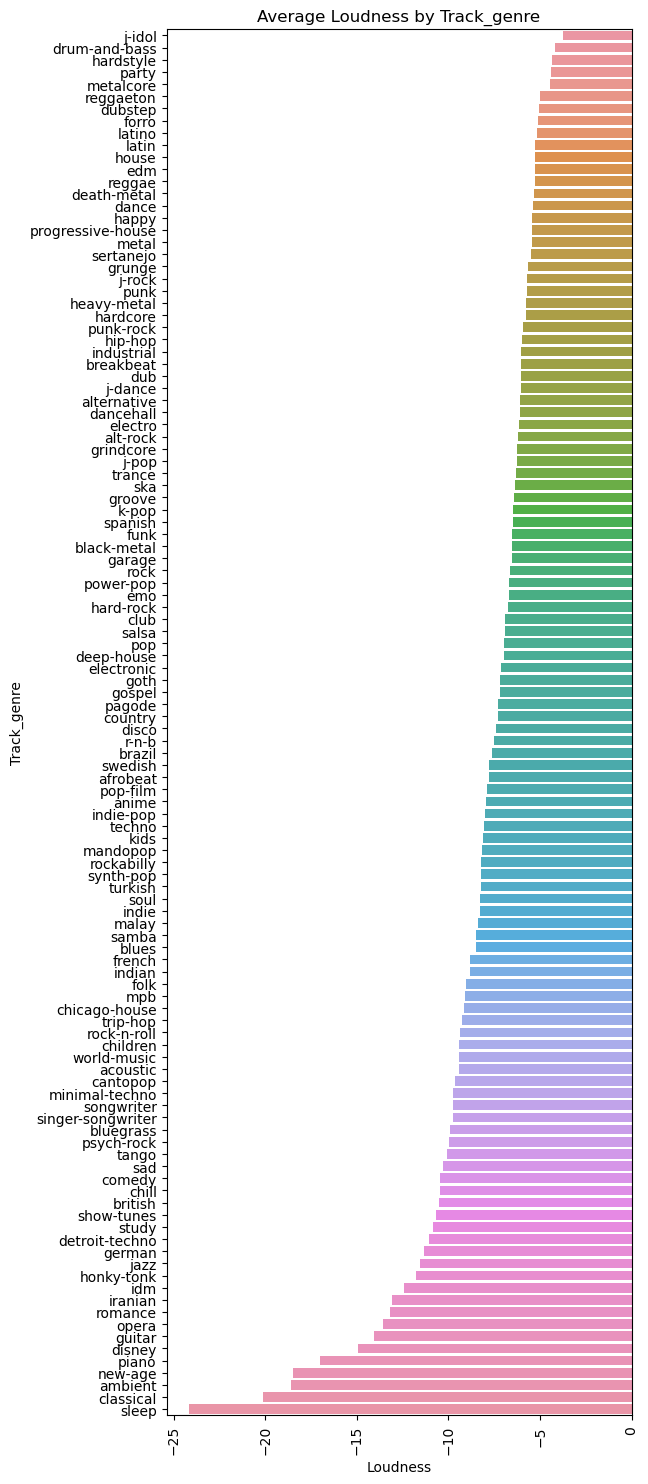

/var/folders/1_/0px29c8j2051nd3xr36_5vwr0000gn/T/ipykernel_9641/713306608.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_df = songs.groupby(category).mean()


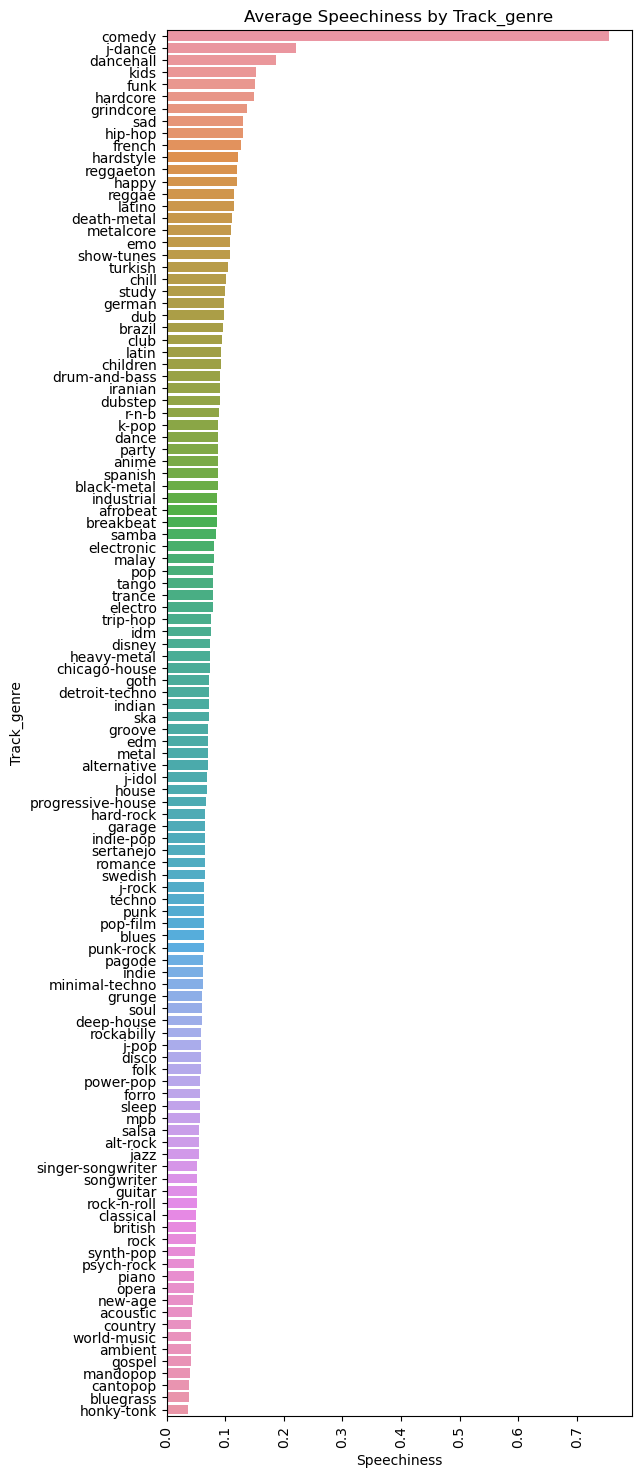

/var/folders/1_/0px29c8j2051nd3xr36_5vwr0000gn/T/ipykernel_9641/713306608.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_df = songs.groupby(category).mean()


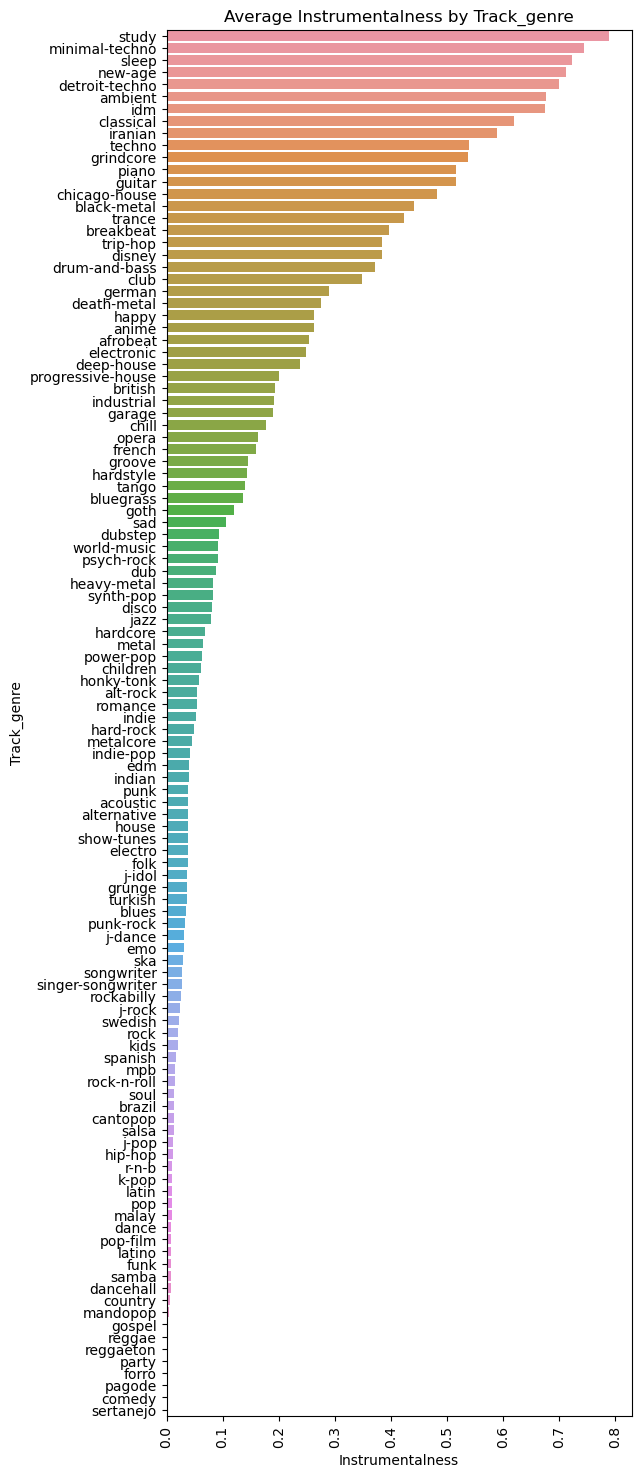

In [18]:
# Create a function that we can call on various attributes to reduce redundancy:

def plot_attributes(songs, attribute, category='track_genre'):
    average_df = songs.groupby(category).mean()
    average_df = average_df.sort_values(by=attribute, ascending=False)
    
    plt.figure(figsize=(6,18))
    sns.barplot(x=attribute, y= average_df.index, data=average_df)
    plt.xticks(rotation=90)

    #Title and axis
    plt.title(f"Average {attribute.capitalize()} by {category.capitalize()}")
    plt.xlabel(attribute.capitalize())
    plt.ylabel(category.capitalize())
    plt.show()
attributes = ['danceability','energy','loudness','speechiness','instrumentalness']
for attribute in attributes:
    plot_attributes(songs, attribute)
    

From these graphs, we see that for danceability, kids music scores the highest. Energy scored highest by death-metal, loudness by j-idol, speechiness by comedy, and study by instrumnetalness.

Going onto preprocessing the data before running our models

In [21]:
songs = songs.drop_duplicates() 
# Let's also remove music classified by language to focus on sound
# attributes 

languages = ['french','latino','turkish','german','brazil','latin','iranian','spanish','malay','indian','swedish','british','cantopop','mandopop']
songs = songs.drop(songs[songs['track_genre'].isin(languages)].index)

In [26]:
# Our data in our graphs is skewed and so we will scale our numerical
# features

from sklearn.preprocessing import StandardScaler, MinMaxScaler

def scale(df, cols_to_scale, scaler_type):
    if scaler_type == 1:
        scaler = StandardScaler()
    elif scaler_type == 2:
        scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[cols_to_scale])
    scaled_df = pd.DataFrame(scaled_data, columns = cols_to_scale)
    df_scaled = pd.concat([df.drop(columns=cols_to_scale).reset_index(drop=True), scaled_df], axis=1)
    return df_scaled

numeric_cols =['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature']
songs = scale(songs, numeric_cols, 1)

Condense the data for each genre to capture what characteristics standouton average. 

/var/folders/1_/0px29c8j2051nd3xr36_5vwr0000gn/T/ipykernel_9641/4181771794.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  genres_average = songs.groupby('track_genre').mean()


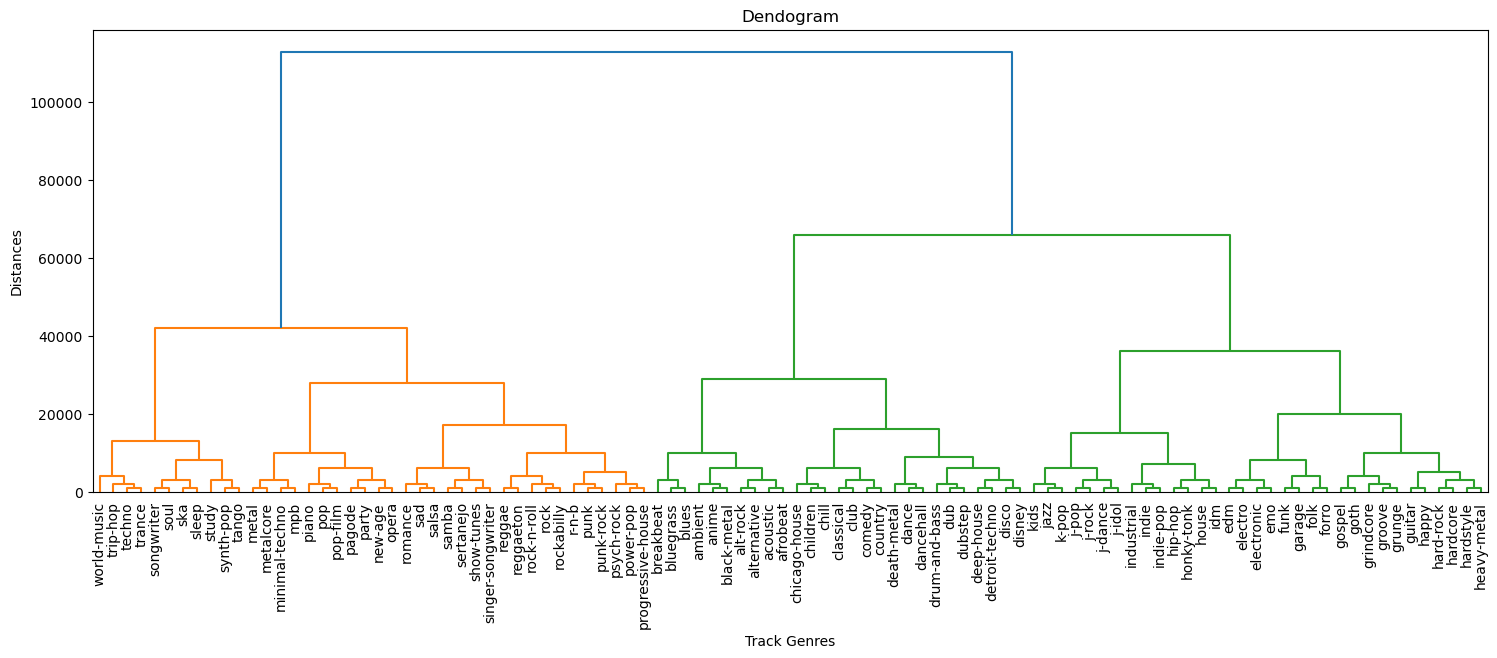

In [29]:
import scipy.cluster.hierarchy as sch

genres_average = songs.groupby('track_genre').mean()
plt.figure(figsize=(18,6))
dendrogram = sch.dendrogram(sch.linkage(genres_average, method='complete'), labels=genres_average.index)
plt.title('Dendogram')
plt.xlabel('Track Genres')
plt.ylabel('Distances')

plt.tick_params(axis='x', labelsize=10)
plt.show()